In [ ]:
import os

os.environ["KAGGLE_USERNAME"] = "ridhij19"
os.environ["KAGGLE_KEY"] = "8de4173b2500ad09e457df08090b8dab"

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip chest-xray-pneumonia.zip -d chest_xray_pneumonia

Archive:  chest-xray-pneumonia.zip
replace chest_xray_pneumonia/chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace chest_xray_pneumonia/chest_xray/__MACOSX/chest_xray/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
%matplotlib inline
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
import skimage
from skimage import io, transform
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

In [ ]:
EPOCHS = 30
data_dir = "/content/chest_xray_pneumonia/chest_xray"
TEST = 'test'
TRAIN = 'train'
VAL ='val'

In [ ]:
def data_transforms(phase):
    if phase == TRAIN:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])

    if phase == VAL:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])

    if phase == TEST:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])

    return transform

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms(x))
                  for x in [TRAIN, VAL, TEST]}

dataloaders = {TRAIN: torch.utils.data.DataLoader(image_datasets[TRAIN], batch_size = 4, shuffle=True),
               VAL: torch.utils.data.DataLoader(image_datasets[VAL], batch_size = 1, shuffle=True),
               TEST: torch.utils.data.DataLoader(image_datasets[TEST], batch_size = 1, shuffle=True)}


In [ ]:
len(dataloaders[TRAIN])

1304

In [ ]:
dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL]}
classes = image_datasets[TRAIN].classes
class_names = image_datasets[TRAIN].classes


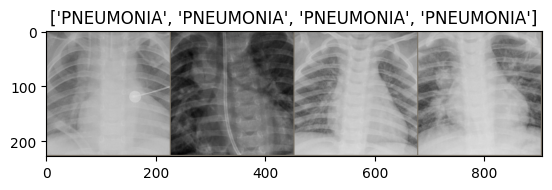

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


inputs, classes = next(iter(dataloaders[TRAIN]))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print("Epoch: {}/{}".format(epoch+1, num_epochs))
        print("="*10)

        for phase in [TRAIN, VAL]:
            if phase == TRAIN:
                scheduler.step()
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            for data in dataloaders[phase]:
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase==TRAIN):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
!kaggle datasets download -d pytorch/vgg16

 97% 473M/490M [00:05<00:00, 134MB/s]
100% 490M/490M [00:05<00:00, 95.9MB/s]


In [ ]:
!unzip vgg16.zip

Archive:  vgg16.zip
  inflating: vgg16.pth               


In [ ]:
##/content/vgg16-transfer-learning-pytorch.ipynb
model_pre = models.vgg16()
model_pre.load_state_dict(torch.load("/content/vgg16.pth"))

<All keys matched successfully>

In [ ]:
for param in model_pre.features.parameters():
    param.required_grad = False

num_features = model_pre.classifier[6].in_features
features = list(model_pre.classifier.children())[:-1]
features.extend([nn.Linear(num_features, len(class_names))])
model_pre.classifier = nn.Sequential(*features)
print(model_pre)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
model_pre = model_pre.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_pre.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)
# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
model_pre = train_model(model_pre, criterion, optimizer, exp_lr_scheduler, num_epochs=EPOCHS)

Epoch: 1/30


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 0.1570 Acc: 0.9394
val Loss: 0.1911 Acc: 0.9375
Epoch: 2/30
train Loss: 0.0733 Acc: 0.9739
val Loss: 0.3634 Acc: 0.8125
Epoch: 3/30
train Loss: 0.0528 Acc: 0.9814
val Loss: 0.1005 Acc: 1.0000
Epoch: 4/30
train Loss: 0.0523 Acc: 0.9816
val Loss: 0.4816 Acc: 0.8125
Epoch: 5/30
train Loss: 0.0472 Acc: 0.9820
val Loss: 0.2101 Acc: 0.8750
Epoch: 6/30
train Loss: 0.0587 Acc: 0.9801
val Loss: 0.1950 Acc: 0.8750
Epoch: 7/30
train Loss: 0.0602 Acc: 0.9764
val Loss: 0.5567 Acc: 0.7500
Epoch: 8/30
train Loss: 0.0573 Acc: 0.9785
val Loss: 0.8193 Acc: 0.6875
Epoch: 9/30
train Loss: 0.0638 Acc: 0.9766
val Loss: 0.3506 Acc: 0.8750
Epoch: 10/30
train Loss: 0.0356 Acc: 0.9879
val Loss: 0.5076 Acc: 0.8125
Epoch: 11/30
train Loss: 0.0316 Acc: 0.9904
val Loss: 0.4231 Acc: 0.8750
Epoch: 12/30
train Loss: 0.0295 Acc: 0.9908
val Loss: 0.4072 Acc: 0.8750
Epoch: 13/30
train Loss: 0.0290 Acc: 0.9902
val Loss: 0.4350 Acc: 0.8750
Epoch: 14/30
train Loss: 0.0263 Acc: 0.9916
val Loss: 0.4552 Acc: 0.8750

In [ ]:
def test_model():
    running_correct = 0.0
    running_total = 0.0
    true_labels = []
    pred_labels = []
    with torch.no_grad():
        for data in dataloaders[TEST]:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            true_labels.append(labels.item())
            outputs = model_pre(inputs)
            _, preds = torch.max(outputs.data, 1)
            pred_labels.append(preds.item())
            running_total += labels.size(0)
            running_correct += (preds == labels).sum().item()
        acc = running_correct/running_total
    return (true_labels, pred_labels, running_correct, running_total, acc)

In [ ]:
true_labels, pred_labels, running_correct, running_total, acc = test_model()

In [ ]:
print("Total Correct: {}, Total Test Images: {}".format(running_correct, running_total))
print("Test Accuracy: ", acc)

Total Correct: 534.0, Total Test Images: 624.0
Test Accuracy:  0.8557692307692307


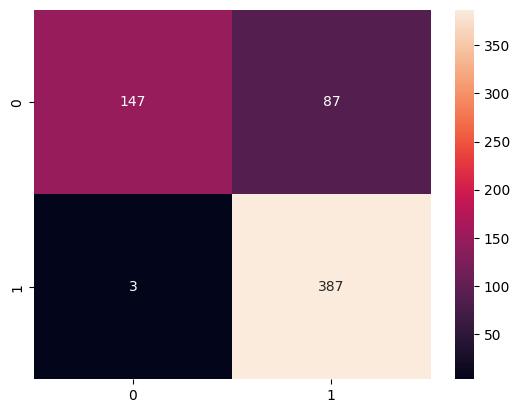

In [ ]:
cm = confusion_matrix(true_labels, pred_labels)
tn, fp, fn, tp = cm.ravel()
ax = sns.heatmap(cm, annot=True, fmt="d")

In [8]:
from IPython.display import display, Markdown



# Create styled text to display test results
result_text =("Total Correct: {}, Total Test Images: {}".format(running_correct, running_total))
result_text += f"**Total Correct:** {running_correct}, **Total Test Images:** {running_total}\n"
result_text += f"**Test Accuracy:** {acc:.2f}%"

# Create a Markdown widget to display the styled text
result_widget = Markdown(result_text)

# Display the styled text
display(result_widget)


Total Correct: 130, Total Test Images: 150**Total Correct:** 130, **Total Test Images:** 150
**Test Accuracy:** 86.70%

In [3]:
import ipywidgets as widgets
from IPython.display import display

# Create radio buttons for class selection
class_radio_buttons = widgets.RadioButtons(
    options=["Normal", "Pneumonia"],
    description="Select Class:",
    disabled=False
)

# Function to display the selected class
def display_selected_class(change):
    selected_class = class_radio_buttons.value
    print(f"Selected class: {selected_class}")

# Attach the function to the radio buttons' change event
class_radio_buttons.observe(display_selected_class, names="value")

# Display the radio buttons
display(class_radio_buttons)


RadioButtons(description='Select Class:', options=('Normal', 'Pneumonia'), value='Normal')

Selected class: Pneumonia
Selected class: Normal
Selected class: Pneumonia


In [9]:
from IPython.display import HTML, display, Javascript

# Simulated values for demonstration
running_correct = 130
running_total = 150
acc = 86.7

# Create styled HTML text for the pop-up window
html_text = f"""
<!DOCTYPE html>
<html>
<head>
<style>
  body {{
    font-family: Arial, sans-serif;
    text-align: center;
    background-color: #f0f0f0;
    padding: 20px;
  }}
  .popup {{
    background-color: #fff;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 20px;
    width: 300px;
    margin: 0 auto;
  }}
</style>
</head>
<body>
<div class="popup">
  <h2>Test Results</h2>
  <p><strong>Total Correct:</strong> {running_correct}</p>
  <p><strong>Total Test Images:</strong> {running_total}</p>
  <p><strong>Test Accuracy:</strong> {acc:.2f}%</p>
</div>
</body>
</html>
"""

# Display the HTML pop-up using IPython.display
display(HTML(html_text))


In [10]:
from IPython.display import HTML, display

# Simulated values for demonstration
running_correct = 130
running_total = 150
acc = 86.7

# Create styled HTML text with colors for the pop-up window
html_text = f"""
<!DOCTYPE html>
<html>
<head>
<style>
  body {{
    font-family: Arial, sans-serif;
    text-align: center;
    background-color: #f0f0f0;
    padding: 20px;
  }}
  .popup {{
    background-color: #f9f9f9;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 20px;
    width: 300px;
    margin: 0 auto;
  }}
  .result {{
    color: #333;
    font-weight: bold;
  }}
</style>
</head>
<body>
<div class="popup">
  <h2 class="result">Test Results</h2>
  <p><strong>Total Correct:</strong> {running_correct}</p>
  <p><strong>Total Test Images:</strong> {running_total}</p>
  <p><strong>Test Accuracy:</strong> {acc:.2f}%</p>
</div>
</body>
</html>
"""

# Display the HTML pop-up using IPython.display
display(HTML(html_text))
